In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

D:\Program Files\anaconda3\envs\trader\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Program Files\anaconda3\envs\trader\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Program Files\anaconda3\envs\trader\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Program Files\anaconda3\envs\trader\lib\site-packages\tensorf

         Date  Time  Open  High  Low  Close
0  2022-01-04    60   203   208  187    206
1  2022-01-04   120   206   209  179    200
2  2022-01-04   180   205   209  179    179
3  2022-01-04   240   179   209  179    180
4  2022-01-04   300   180   209  179    209


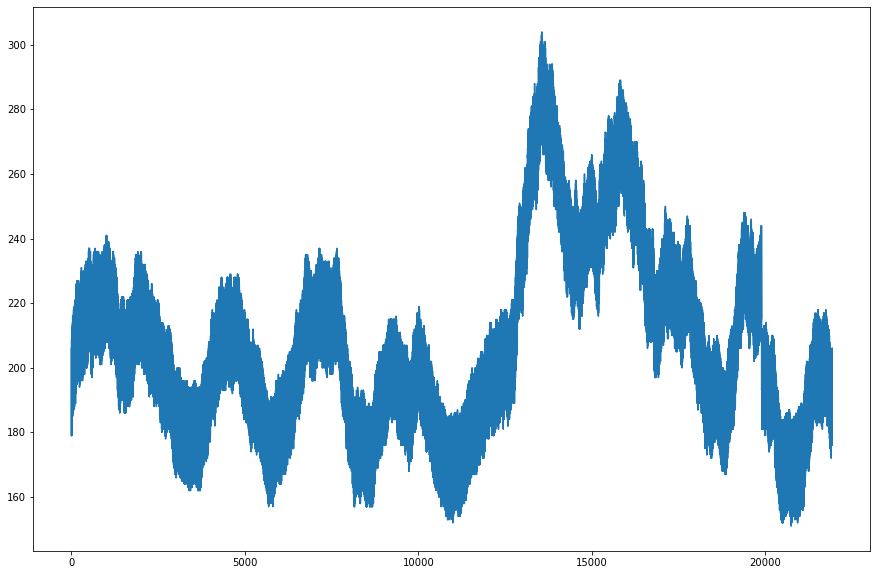

In [3]:
# Read the csv file
df = pd.read_csv('../clean_data/integrated_candlesticks60.csv')
print(df.head())
price = df.Close
fig, ax = plt.subplots(figsize=(15, 10))
x = range(len(price))
plt.plot(x, price)
# plt.xlim([200, 400])
plt.show()

In [4]:
# preprocessing 
# select cols [2:6]
cols = list(df)[2:6]
df_4cols = df[cols].astype(float)

# split train test
split_rate = 0.7
split_index = int(len(df)*0.7)
unscaled_train_df = df_4cols.iloc[:split_index]
unscaled_test_df = df_4cols.iloc[split_index+1:]

# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(unscaled_train_df)
train_df = scaler.transform(unscaled_train_df)
test_df = scaler.transform(unscaled_test_df)

print(unscaled_train_df.head())
print(unscaled_test_df.head())

print(np.shape(train_df))
print(np.shape(test_df))

    Open   High    Low  Close
0  203.0  208.0  187.0  206.0
1  206.0  209.0  179.0  200.0
2  205.0  209.0  179.0  179.0
3  179.0  209.0  179.0  180.0
4  180.0  209.0  179.0  209.0
        Open   High    Low  Close
15351  260.0  265.0  235.0  239.0
15352  264.0  265.0  234.0  265.0
15353  265.0  265.0  234.0  235.0
15354  236.0  266.0  235.0  266.0
15355  266.0  266.0  235.0  252.0
(15350, 4)
(6579, 4)


In [185]:
# Empty lists to be populated using formatted training data
trainX = []
trainY = []
testX = []
testY = []

n_future = 10 + 1   # Number of days we want to look into the future based on the past days.
n_past = 20  # Number of past days we want to use to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
# reformat train
for i in range(n_past, len(train_df) - n_future +1):
    trainX.append(train_df[i - n_past:i, 0:train_df.shape[1]])
    trainY.append(train_df[i + 1 :i + n_future, 0])
# reformat test
for i in range(n_past, len(test_df) - n_future +1):
    testX.append(test_df[i - n_past:i, 0:test_df.shape[1]])
    testY.append(test_df[i + 1 :i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (15320, 20, 4).
trainY shape == (15320, 10).
testX shape == (6549, 20, 4).
testY shape == (6549, 10).


In [186]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 20, 64)            17664     
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________


Train on 13788 samples, validate on 1532 samples
Epoch 1/30
13788/13788 [==============================] - 8s 546us/sample - loss: 0.3327 - val_loss: 0.2385
Epoch 2/30
13788/13788 [==============================] - 5s 382us/sample - loss: 0.2385 - val_loss: 0.2423
Epoch 3/30
13788/13788 [==============================] - 5s 346us/sample - loss: 0.2288 - val_loss: 0.2290
Epoch 4/30
13788/13788 [==============================] - 5s 354us/sample - loss: 0.2220 - val_loss: 0.2193
Epoch 5/30
13788/13788 [==============================] - 5s 358us/sample - loss: 0.2190 - val_loss: 0.2176
Epoch 6/30
13788/13788 [==============================] - 5s 349us/sample - loss: 0.2180 - val_loss: 0.2193
Epoch 7/30
13788/13788 [==============================] - 5s 354us/sample - loss: 0.2155 - val_loss: 0.2163
Epoch 8/30
13788/13788 [==============================] - 5s 349us/sample - loss: 0.2154 - val_loss: 0.2160
Epoch 9/30
13788/13788 [==============================] - 5s 363us/sample - loss: 0.214

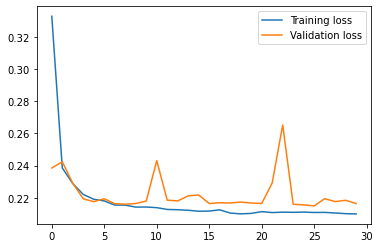

In [187]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [153]:
# # fit on training set
# pred_trainY = []
# for sample in trainX:
#     pred_trainY.append(model.predict(np.reshape(sample,(1,n_past,trainX.shape[2]))))
# print(np.shape(pred_trainY))
# print(np.shape(true_y))

# # inverse pre_trainY
# pred_trainY = np.reshape(np.array(pred_trainY), (len(pred_trainY),1))
# prediction_copies = np.repeat(pred_trainY, trainX.shape[2], axis=-1)
# pred_trainY = scaler.inverse_transform(prediction_copies)[:,0]
# print(pred_trainY[:5])

In [154]:
# # plot prediction fit in train set
# time_start = 500
# time_end = 600

# fig, ax = plt.subplots(figsize=(15, 10))
# x=range(len(train_df))
# true_y = unscaled_train_df['Open']
# plt.plot(x, true_y, label='true')
# plt.plot(x[n_past:], pred_trainY, label='predict')
# plt.legend()
# # plt.xlim([time_start, time_end])
# plt.show()

In [155]:
# # fit in test set - one step ahead
# pred_testY = []
# for sample in testX:
#     pred_testY.append(model.predict(np.reshape(sample,(1,n_past,trainX.shape[2]))))
# print(np.shape(pred_testY))

# # inverse pred_testY
# pred_testY = np.reshape(np.array(pred_testY), (len(pred_testY),1))
# prediction_copies = np.repeat(pred_testY, testX.shape[2], axis=-1)
# pred_testY = scaler.inverse_transform(prediction_copies)[:,0]

(6559, 1, 1)


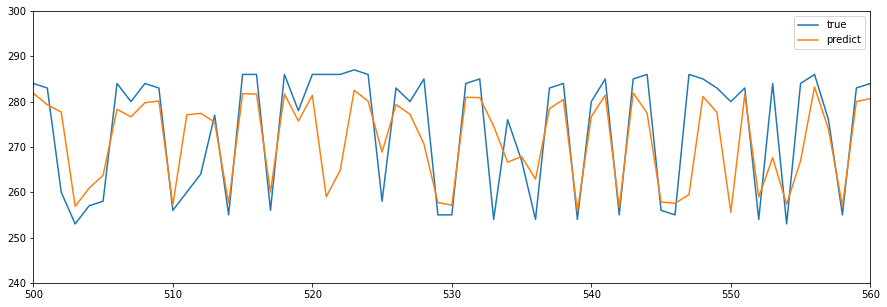

In [156]:
# # plot prediction fit in test set - one step ahead
# time_start = 500
# time_end = 560

# fig, ax = plt.subplots(figsize=(15, 5))
# x=range(len(unscaled_test_df))
# true_y = unscaled_test_df['Open']
# plt.plot(x, true_y, label='true')
# plt.plot(x[n_past:], pred_testY, label='predict')
# plt.legend()
# plt.xlim([time_start, time_end])
# plt.ylim([240, 300])
# plt.show()

In [199]:
print(len(unscaled_test_df))
print(n_future)

6579
11


In [208]:
# fit in test set - n step ahead
pred_testY = []
for sample_index in range(0, len(testX)-10, 10):
    pred = model.predict(np.reshape(testX[sample_index],(1,n_past,trainX.shape[2])))
    # pred = np.reshape(pred,(10))
    pred_testY.append(pred)
pred_testY = np.array(pred_testY)
pred_testY = pred_testY.flatten()
print(np.shape(pred_testY))

(6540,)


In [209]:
# inverse pred_testY
pred_testY = np.reshape(np.array(pred_testY), (len(pred_testY),1))
prediction_copies = np.repeat(pred_testY, testX.shape[2], axis=-1)
pred_testY = scaler.inverse_transform(prediction_copies)[:,0]

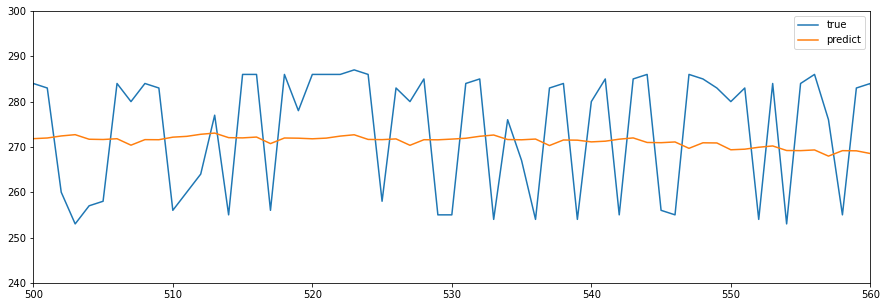

In [216]:
# plot prediction fit in test set - n step ahead
time_start = 500
time_end = 560

fig, ax = plt.subplots(figsize=(15, 5))
x=range(len(pred_testY))
true_y = unscaled_test_df['Open']
plt.plot(x, true_y[:len(pred_testY)], label='true')
plt.plot(x, pred_testY, label='predict')
plt.legend()
plt.xlim([time_start, time_end])
plt.ylim([240, 300])
plt.show()

In [157]:
print(testX[6])

[[1.86129459 1.76939648 1.748502   1.83308484]
 [1.93311246 1.7306265  1.70955438 1.36580882]
 [1.64584098 1.7306265  1.70955438 1.79714053]
 [1.71765885 1.7306265  1.70955438 1.94091777]
 [1.93311246 1.76939648 1.78744961 2.01280639]
 [1.96902139 1.80816647 1.78744961 2.01280639]
 [1.96902139 1.80816647 1.78744961 1.15014296]
 [1.03538909 1.84693646 1.82639723 1.94091777]
 [1.82538565 1.84693646 1.82639723 2.01280639]
 [1.96902139 1.84693646 1.82639723 2.0487507 ]
 [2.00493033 1.88570644 1.82639723 2.01280639]
 [2.00493033 1.92447643 1.90429247 2.0487507 ]
 [2.04083926 1.88570644 1.90429247 1.04231004]
 [0.99948016 1.88570644 1.90429247 1.04231004]
 [0.99948016 1.92447643 1.90429247 1.6893076 ]
 [1.68174992 1.92447643 1.94324009 1.79714053]
 [1.03538909 1.96324641 1.94324009 2.084695  ]
 [2.04083926 1.96324641 1.94324009 1.86902915]
 [1.89720352 2.0020164  1.98218771 1.11419865]
 [1.07129803 1.96324641 1.94324009 2.15658362]]


In [163]:
# n_future > 2
n_future = 10
pred_testY = []
for sample_index in range(0,len(testX)-n_future,n_future):
# for sample_index in range(0,5,n_future):
    for n in range(n_future):
        tmp = testX[sample_index+n]
        if n != 0:
            # tmp[-n:,:] = pred_testY[sample_index:sample_index+n]
            tmp[-n:,:] = pred_testY[sample_index:sample_index+n]
            # tmp[-n:,1:4] = 0
        # print(tmp)
        pred = model.predict(np.reshape(tmp,(1,n_past,trainX.shape[2])))
        # print(pred)
        pred_testY.append(pred)

D:\Program Files\anaconda3\envs\trader\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  # Remove the CWD from sys.path while we load stuff.


In [164]:
# inverse pred_testY
pred_testY = np.reshape(np.array(pred_testY), (len(pred_testY),1))
prediction_copies = np.repeat(pred_testY, testX.shape[2], axis=-1)
pred_testY = scaler.inverse_transform(prediction_copies)[:,0]
print(pred_testY[:5])
true_y = unscaled_test_df['Open']
print(true_y[:5])

[241.71466 241.67441 241.15782 240.34799 239.38301]
15351    260.0
15352    264.0
15353    265.0
15354    236.0
15355    266.0
Name: Open, dtype: float64


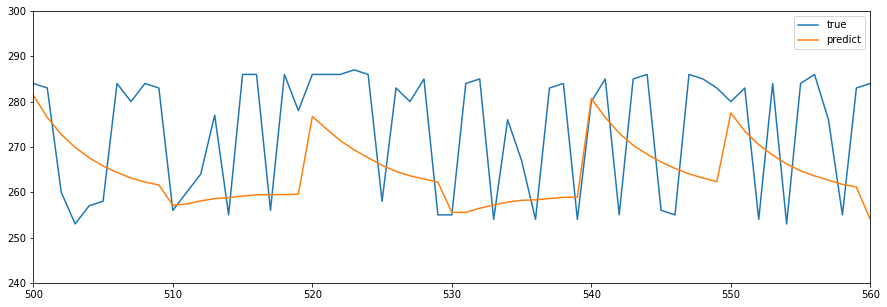

In [166]:
# plot prediction fit in train set
time_start = 500
time_end = 560

x=range(len(pred_testY))
true_y = unscaled_test_df['Open']
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(x, true_y[:len(pred_testY)], label='true')
plt.plot(x, pred_testY, label='predict')
plt.legend()
plt.xlim([time_start, time_end])
plt.ylim([240, 300])
plt.show()

In [67]:
# # evaluate
# from sklearn.metrics import mean_squared_error
# rmse = np.sqrt(mean_squared_error(true_y[n_past:], pred_testY))
# print(rmse)

In [29]:
# singlevariate

# preprocessing 
# select cols [2:6]
cols = list(df)[2]
df_4cols = df[cols].astype(float)


# split train test
split_rate = 0.7
split_index = int(len(df)*0.7)
unscaled_train_df = df_4cols.iloc[:split_index]
unscaled_test_df = df_4cols.iloc[split_index+1:]

print(df_4cols)

0        203.0
1        206.0
2        205.0
3        179.0
4        180.0
         ...  
21925    206.0
21926    202.0
21927    198.0
21928    177.0
21929    206.0
Name: Open, Length: 21930, dtype: float64


In [50]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
unscaled_train_df = np.array(unscaled_train_df)
unscaled_test_df = np.array(unscaled_test_df)
scaler = scaler.fit(np.reshape(unscaled_train_df, (-1,1)))
train_df = scaler.transform(np.reshape(unscaled_train_df, (-1,1)))
test_df = scaler.transform(np.reshape(unscaled_test_df, (-1,1)))

# print(unscaled_train_df.head())
# print(unscaled_test_df.head())
# print(np.shape(train_df))
# print(np.shape(test_df))



n_future = 1
n_past = 20

# Empty lists to be populated using formatted training data
trainX = []
trainY = []
testX = []
testY = []

n_future = 11   # Number of days we want to look into the future based on the past days.
n_past = 20  # Number of past days we want to use to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
# reformat train
for i in range(n_past, len(train_df) - n_future +1):
    trainX.append(np.reshape(train_df[i - n_past:i,0],(n_past,1)))
    trainY.append(train_df[i + 1 :i + n_future, 0])
# reformat test
for i in range(n_past, len(test_df) - n_future +1):
    testX.append(np.reshape(test_df[i - n_past:i, 0],(n_past,1)))
    testY.append(test_df[i + 1 :i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (15320, 20, 1).
trainY shape == (15320, 10).
testX shape == (6549, 20, 1).
testY shape == (6549, 10).


In [51]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 29,642
Trainable params: 29,642
Non-trainable params: 0
_________________________________________________________________


Train on 13788 samples, validate on 1532 samples
Epoch 1/30
13788/13788 [==============================] - 7s 519us/sample - loss: 0.3456 - val_loss: 0.2373
Epoch 2/30
13788/13788 [==============================] - 5s 373us/sample - loss: 0.2376 - val_loss: 0.2551
Epoch 3/30
13788/13788 [==============================] - 4s 326us/sample - loss: 0.2264 - val_loss: 0.2243
Epoch 4/30
13788/13788 [==============================] - 4s 324us/sample - loss: 0.2208 - val_loss: 0.2231
Epoch 5/30
13788/13788 [==============================] - 4s 317us/sample - loss: 0.2187 - val_loss: 0.2413
Epoch 6/30
13788/13788 [==============================] - 4s 319us/sample - loss: 0.2171 - val_loss: 0.2272
Epoch 7/30
13788/13788 [==============================] - 4s 314us/sample - loss: 0.2157 - val_loss: 0.2246
Epoch 8/30
13788/13788 [==============================] - 4s 317us/sample - loss: 0.2130 - val_loss: 0.2227
Epoch 9/30
13788/13788 [==============================] - 4s 317us/sample - loss: 0.213

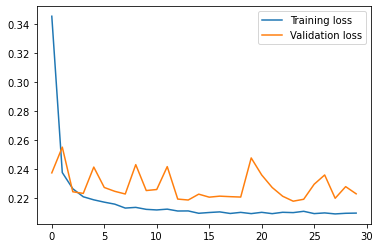

In [52]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [54]:
# fit in test set - n step ahead
pred_testY = []
for sample_index in range(0, len(testX)-10, 10):
    pred = model.predict(np.reshape(testX[sample_index],(1,n_past,trainX.shape[2])))
    # pred = np.reshape(pred,(10))
    pred_testY.append(pred)
pred_testY = np.array(pred_testY)
pred_testY = pred_testY.flatten()
print(np.shape(pred_testY))

# inverse pred_testY
pred_testY = np.reshape(np.array(pred_testY), (len(pred_testY),1))
prediction_copies = np.repeat(pred_testY, testX.shape[2], axis=-1)
pred_testY = scaler.inverse_transform(prediction_copies)[:,0]

(6540,)


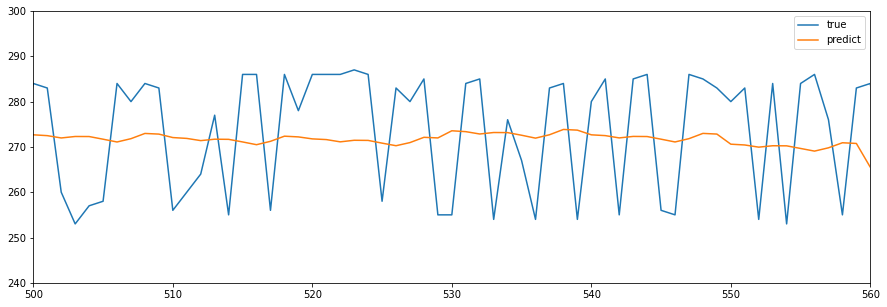

In [56]:
# plot prediction fit in test set - n step ahead
time_start = 500
time_end = 560

fig, ax = plt.subplots(figsize=(15, 5))
x=range(len(pred_testY))
true_y = unscaled_test_df
plt.plot(x, true_y[:len(pred_testY)], label='true')
plt.plot(x, pred_testY, label='predict')
plt.legend()
plt.xlim([time_start, time_end])
plt.ylim([240, 300])
plt.show()

In [77]:
# n_future > 2
n_future = 10
pred_testY = []
# for sample_index in range(0,len(testX)-n_future,n_future):
for sample_index in range(0,5,n_future):
    for n in range(n_future):
        tmp = testX[sample_index+n]
        # print(tmp)
        if n != 0:
            # tmp[-n:,:] = pred_testY[sample_index:sample_index+n]
            tmp[-n:,0] = np.reshape(pred_testY[sample_index:sample_index+n],(-1,1))
#             print(np.reshape(pred_testY[sample_index:sample_index+n], (-1,1)))
#             print(tmp[-n:,0])
            # tmp[-n:,1:4] = 0
        # print(tmp)
        pred = model.predict(np.reshape(tmp,(1,n_past,trainX.shape[2])))
        # print(pred)
        pred_testY.append(pred)
        
# inverse pred_testY
pred_testY = np.reshape(np.array(pred_testY), (len(pred_testY),1))
prediction_copies = np.repeat(pred_testY, testX.shape[2], axis=-1)
pred_testY = scaler.inverse_transform(prediction_copies)[:,0]
print(pred_testY[:5])
true_y = unscaled_test_df
print(true_y[:5])

ValueError: could not broadcast input array from shape (10,1) into shape (1,)